# 최종 모델로 2023년 8월 ~ 2024년 7월의 IOD 예측

## 라이브러리 불러오기

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv3D, ConvLSTM2D, BatchNormalization
from keras import callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import netCDF4 as nc
import pandas as pd

## 데이터 불러오기

data path 설정

In [2]:
official_data_path = './official_data/'
our_data_path = './val_test_data/'

실제 iod, sst 데이터 xarray로 불러오기

In [3]:
xr_iod = xr.open_dataset(official_data_path+'iod.nc')
# xr_iod = xr.open_dataset(official_data_path+'iod.nc', decode_time=False)

xr_raw_sst = xr.open_dataset(official_data_path+'sst.anom.mon.mean.nc')

d:\anaconda3\envs\final_sealab\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [4]:
xr_iod

<xarray.Dataset>
Dimensions:  (time: 499, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2023-07-01
  * lon      (lon) float64 1.0
  * lat      (lat) float64 1.0
Data variables:
    iod      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Aug 25 15:59:59 2023: cdo -f nc import_binary iod.ctl i...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

IOD 예측을 위해 저장해 놓은 test set 불러오기

In [5]:
x_test = np.load(our_data_path + 'test.npy')

## 모델 불러와 iod 예측

모델 저장 경로 및 불러올 모델(전 범위의 sst로 학습했고 masking value가 mean이며 epochs는 20인 모델) 선언

In [16]:
model_path = './models/'
model_name = 'final_model.h5'

모델 불러오기

In [17]:
model = load_model(model_path + model_name, compile=False)

### 예측 실행

In [18]:
# 데이터를 xarray로 만드는 함수 선언
def to_xr(data):
  return xr.DataArray(
    data=data,
    dims = ['time', 'lat', 'lon'],
    coords = dict(
        lon = ('lon', xr_raw_sst.lon.data),
        lat = ('lat', xr_raw_sst.lat.data),
        time = ('time', pd.date_range('2023-08-01', periods=12, freq='MS'))
        )
    )

# sst 평균으로 iod 구하는 함수 선언
def wtio_setio_iod(xr_sst):
  wtio_sst = xr_sst.sel(lat=slice(-10, 10), lon=slice(50, 70)).data
  setio_sst = xr_sst.sel(lat=slice(-10, 0), lon=slice(90, 110)).data

  wtio_sst_mean = [np.nanmean(wtio_sst[i]) for i in range(len(wtio_sst))]
  setio_sst_mean = [np.nanmean(setio_sst[i]) for i in range(len(setio_sst))]

  iod = [wtio_sst_mean[i] - setio_sst_mean[i] for i in range(len(wtio_sst))]

  return wtio_sst, setio_sst, iod

In [19]:
# 마스킹 해제 위해 마스킹된 인덱스값 가져오기
nc_raw_sst = nc.Dataset(official_data_path+'sst.anom.mon.mean.nc')
masked = nc_raw_sst['sst'][:].mask
masked = masked[-12:]

In [20]:
# 예측값을 확인하기 위한 함수 선언
def predict_iod(model, data):
    # 불러온 모델로 예측 실행
    pred = model.predict(data)
    pred = pred[:, 3, ...].reshape((12, 180, 360))

    # 마스킹 했던 부분을 다시 nan으로 변환
    pred[masked] = np.nan

    # 예측 데이터를 xarray 형태로 변환
    xr_pred = to_xr(pred)

    # 예측 데이터로 iod 구하기
    pred_wtio_sst, pred_setio_sst, pred_iod =  wtio_setio_iod(xr_pred)

    return pred_iod

In [21]:
# 예측 실행하여 예측한 iod 값 저장
pred_iod = predict_iod(model, x_test)

1/1 [==============================] - 13s 13s/step


In [22]:
# 예측값 확인
print(pred_iod)

[-0.22664869, -0.1693061, -0.2484617, -0.1896427, -0.10869644, -0.12731332, 0.006789975, 0.041186336, 0.08737946, -0.040354423, -0.12304734, 0.04226166]


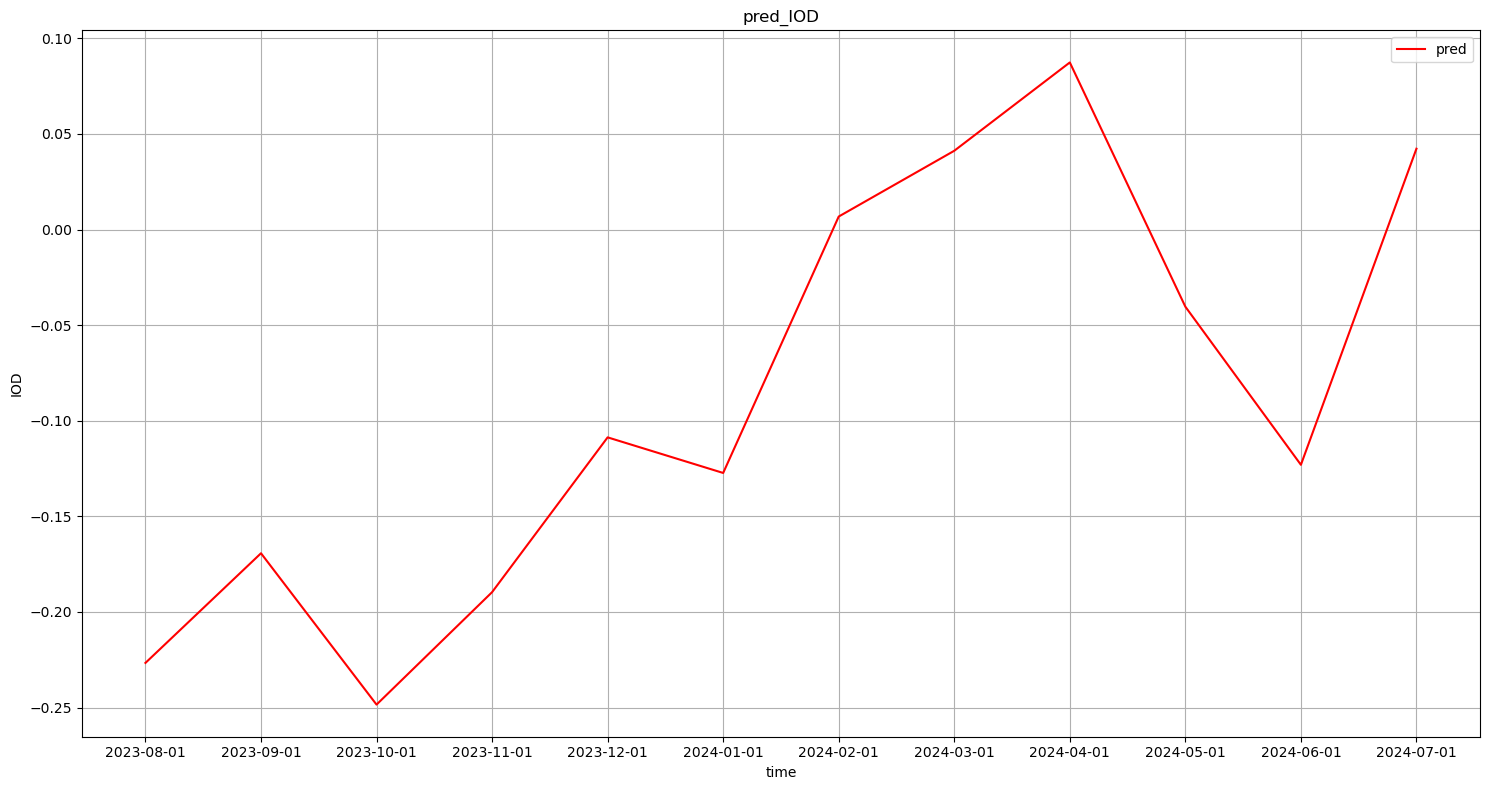

In [23]:
# 예측한 iod 값 plotting하여 비교

test_month_list = ['2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01']

plt.figure(figsize=(15,8))

plt.plot(test_month_list, pred_iod, label='pred', color='red')
plt.title('pred_IOD')
plt.xlabel('time')
plt.ylabel('IOD')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

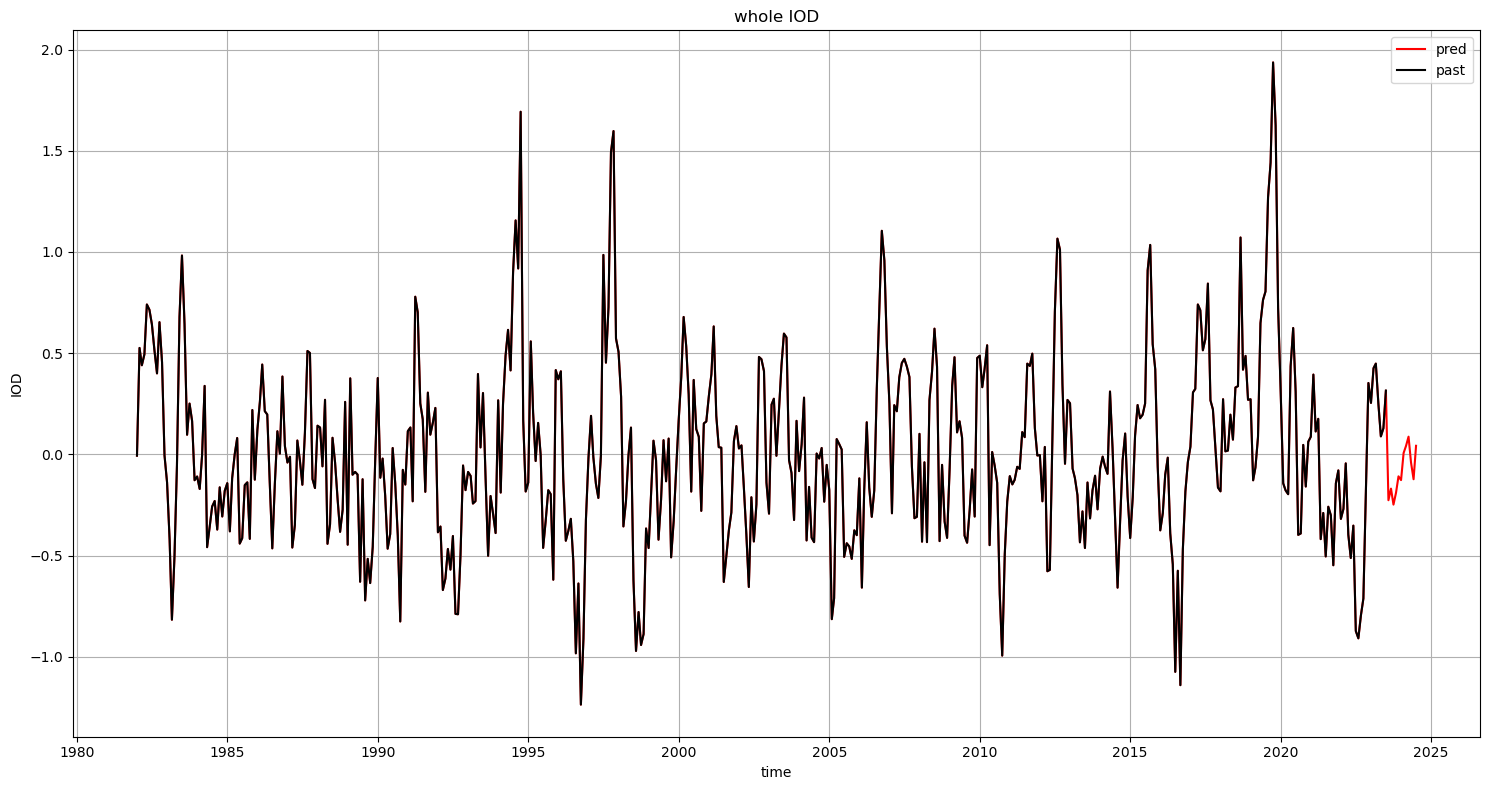

In [24]:
# 전체에 넣어서 비교

whole_month = pd.date_range('1982-01-01', periods=511, freq='MS')
past_month = pd.date_range('1982-01-01', periods=499, freq='MS')
true_iod = [i[0][0] for i in xr_iod['iod'][:].data[:]]

plt.figure(figsize=(15,8))
plt.plot(whole_month, true_iod+pred_iod, label='pred', color='red')
plt.plot(past_month, true_iod, label='past', color='black')
plt.title('whole IOD')
plt.xlabel('time')
plt.ylabel('IOD')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()